# AdaBoost classifier (1.5 points)

In this assignment, your task is to train an AdaBoost classifier on synthetic data. For reference, you are  provided with the posterior $P(y=1 \mid x)$, with $x$ regularly sampled over the domain $\mathcal{D} = [0,1]\times[0,1]$, so that you can see how the output of the AdaBoost classifier better approximates the posterior at each round.                

 - Question 1 (1.) Implement the Adaboost algorithm described in class. This involves iterating over the following steps:
  - a. Find the best decision stump at each round.
  - b. Using the weak learner's weighted error, compute $\alpha_t$.
  - c. Update the weight distribution of the training samples.
 - Question 2 (.3) Modify your loop to compute the loss $E_t = E(f_t(\mathbf{x}),\mathbf{y}) = \sum_{i=1}^{N} \exp(-y^i f_t(x^i))$ at each round. Then, plot $E_t$ and make sure that it is monotonically decreasing with time. Verify that $E_t$ provides an upper bound for the number of errors.
 - Question 3 (.2) First show the approximate posterior of your strong learner side-by-side with the original posterior. Then, show the approximate posteriors for each step at which the learner's response has been saved. Make sure that they look increasingly similar to the original posterior.

# Code

## Imports

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from construct_data import construct_data

## Visualize training data and posterior

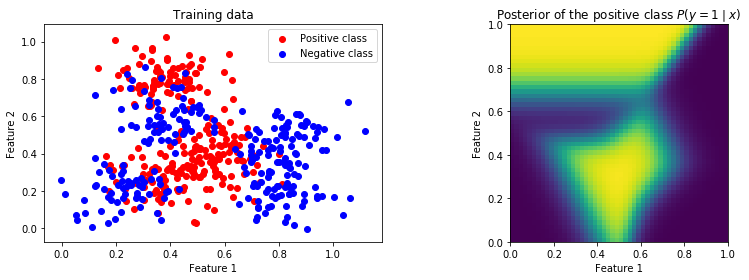

In [62]:
features, labels, posterior = construct_data(500, 'train', 'nonlinear', plusminus=True)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")

ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()

## Train the classifier

### Design the method to find the best decision stump

Notes on the implementation:
 - At each round, the best weak learner is the one with the lowest *weighted error* (defined as the sum of the weights of each misclassified point).
 - The form of a decision stump is $f(x) =  s (2[x_{d}\geq\theta] - 1)$, where $d$ is the the dimension along which the decision is taken, $[\cdot]$ is 1 if $\cdot$ is true and 0 otherwise, $\theta$ is the threshold applied along dimension $d$ and $s\in\{-1,1\}$ is the polarity of the decision stump (this is a multiplicative factor, not a function!).  
   For example, if $s = 1$, the decision stump will consider that all samples whose $d$-th feature is greater than $\theta$ are in the positive class, and all samples with a feature strictly lower than $\theta$ are in the negative class.
 - When searching for the best decision stump, one needs in principle to consider all possible combinations of $\theta,d,s$. However, as discussed in class, for a given dimension $d$ the only values of $\theta$ that actually matter are the values taken on by the training set features along that dimension.

### Define the stump evaluation functions

In [63]:
def evaluate_stump(features, coordinate_wl, polarity_wl, theta_wl):
    """Evaluate the classifier's response for each point."""
    feature_slice = features[:, coordinate_wl]
    if polarity_wl == 1:
        crit = (feature_slice >= theta_wl)
    else:
        crit = (feature_slice <= theta_wl)
    weak_learner_output = 2*crit - 1

    return weak_learner_output


def evaluate_stump_on_grid(x_rng, y_rng, coordinate_wl, polarity_wl, theta_wl):
    """Evaluate the classifier's response for each point on a rectangular grid."""
    grx, gry = np.meshgrid(x_rng, y_rng)
    if coordinate_wl == 0:
        feature_slice = grx
    else:
        feature_slice = gry

    if polarity_wl == 1:
        crit = feature_slice >= theta_wl
    else:
        crit = feature_slice <= theta_wl
    weak_learner_on_grid = 2*crit - 1

    return weak_learner_on_grid

In [64]:
def find_best_weak_learner(weights, features, labels):
    """Find the best decision stump for the given weight distribution.
    
    Returns
    -------
    coordinate_wl : int
      Dimension 'd' along which the threshold is applied.
    polarity_wl : {-1, 1}
      Polarity 's' of the decision stump.
    theta_wl : float
      Threshold for the decision
    err_wl : float
      Weighted error for the decision stump.

    """
    coordinate_wl = 0
    polarity_wl = 1
    theta_wl = 0.
    err_wl = np.inf

    for d in range(features.shape[1]):
        for theta in features[:, d]:
            for s in [-1, 1]:
                
                # Compute error for this classifier as sum of 
                # weights of misclassified points.
                error = 0.0
                output = evaluate_stump(features, d, s, theta)
                misclassified = output != labels
                error = np.sum(misclassified * weights)
                        
                if error < err_wl:
                    err_wl = error
                    coordinate_wl = d
                    polarity_wl = s
                    theta_wl = theta             
    ## /TODO (Question 1)
    return coordinate_wl, polarity_wl, theta_wl, err_wl

### Run the algorithm

In [65]:
from math import log, exp

In [66]:
def evaluate_stump_single_point(features, coordinate_wl, polarity_wl, theta_wl):
    """Evaluate the classifier's response for a single point."""
    if polarity_wl == 1:
        crit = features[coordinate_wl] >= theta_wl
    else:
        crit = features[coordinate_wl] <= theta_wl
    weak_learner_output = 2 * crit - 1

    return weak_learner_output

In [67]:
npoints, nfeatures = features.shape
num_rounds_boosting = 400


# Initialize arrays.
weights = np.ones(npoints) / npoints  # Weight distribution on samples
f = np.zeros((num_rounds_boosting, npoints))  # Overall classifier response at each iteration
loss = np.zeros(num_rounds_boosting)  # AdaBoost loss function

f_on_grid = 0  # Used to plot function
x_rng = y_rng = np.linspace(0, 1, 50)

for i in range(num_rounds_boosting):
    ## TODO (Question 1)
    # Find best weak learner at current round of boosting.
    # (You need to complete the code of find_best_weak_learner.)
    coordinate_wl, polarity_wl, theta_wl, err_wl = find_best_weak_learner(weights, features, labels)
    # Estimate alpha.
    alpha_t = (1 / 2) * np.log((1 - err_wl) / err_wl)
    
    weights = weights * np.exp(-alpha_t  * labels * evaluate_stump(features, coordinate_wl, polarity_wl, theta_wl))
    Z_t = np.sum(weights)
    weights = weights / Z_t
    ## /TODO (Question 1)

    ## TODO (Question 2)
    # Compute overall response at current round.
    if i > 0:
        f[i] = f[i-1] + alpha_t * evaluate_stump(features, coordinate_wl, polarity_wl, theta_wl)
    else:
        f[i] = alpha_t * evaluate_stump(features, coordinate_wl, polarity_wl, theta_wl)
    # Compute loss at current round.
    loss[i] = sum([exp((-1) * res) for res in (labels * f[i])])
    ## /TODO (Question 2)

    # Evaluate f on a grid to produce the images.
    weak_learner_on_grid = evaluate_stump_on_grid(x_rng, y_rng, coordinate_wl, polarity_wl, theta_wl)
    f_on_grid += alpha_t*weak_learner_on_grid
    # Save gridded f at specific iterations.
    if i == 10:
        f_10 = f_on_grid.copy()
    elif i == 50:
        f_50 = f_on_grid.copy()
    elif i == 100:
        f_100 = f_on_grid.copy()

## Visualize loss function

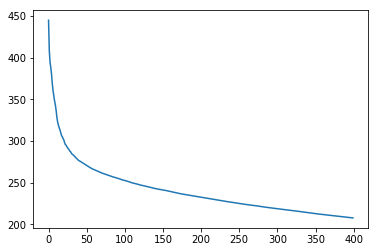

In [68]:
plt.figure()
plt.plot(loss, label="Loss")
plt.show()

## Visualize strong learner progress

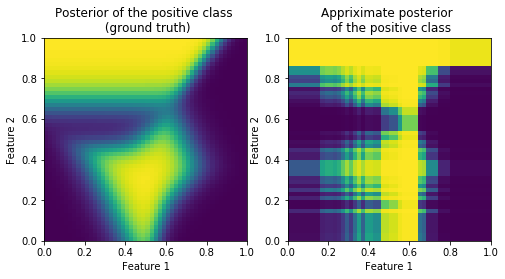

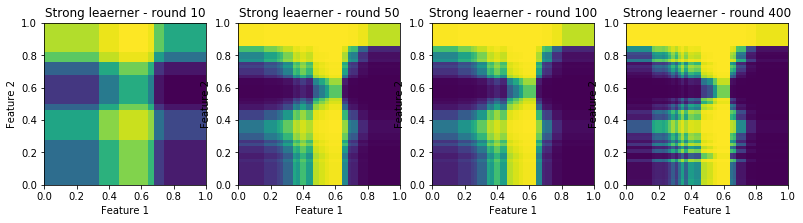

In [71]:
approx_posterior_10 = 1 / (1 + np.exp(-2 * f_10))
approx_posterior_50 = 1 / (1 + np.exp(-2 * f_50))
approx_posterior_100 = 1 / (1 + np.exp(-2 * f_100))
approx_posterior_400 = 1 / (1 + np.exp(-2 * f_on_grid))

## TODO (Question 3)
# Display data
fig1 = plt.figure(figsize=plt.figaspect(0.5))

ax = fig1.add_subplot(1, 2, 1)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class \n (ground truth)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig1.add_subplot(1, 2, 2)
ax.imshow(approx_posterior_400, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Appriximate posterior \n of the positive class")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 4, 1)
ax.imshow(approx_posterior_10, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong leaerner - round 10")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 4, 2)
ax.imshow(approx_posterior_100, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong leaerner - round 50")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 4, 3)
ax.imshow(approx_posterior_100, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong leaerner - round 100")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 4, 4)
ax.imshow(approx_posterior_400, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Strong leaerner - round 400")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()## /TODO (Question 3)

plt.show()